# Evalutation des models

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from six.moves import urllib
from zipfile import ZipFile
import math
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [4]:
DOWNLOAD_ROOT = "https://github.com/Teerath67/Projet-IA/raw/master/data.zip"
DATA_PATH = os.path.join("datasets", "data")

MANAGER_SURVEY_CSV = "manager_survey_data.csv"
EMPLOYEE_SURVEY_CSV = "employee_survey_data.csv"
GENERAL_CSV = "general_data.csv"
IN_TIME_CSV = "in_time.csv"
OUT_TIME_CSV = "out_time.csv"

def fetch_data(download_url=DOWNLOAD_ROOT, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "data.zip")
    urllib.request.urlretrieve(download_url, zip_path)
    data_zip = ZipFile(zip_path, 'r')
    data_zip.extractall(path=data_path)
    data_zip.close()

def load_data(general_path, csv):
    csv_path = os.path.join(general_path, csv)
    df = pd.read_csv(csv_path, sep=",", header = 0)
    return df

fetch_data()

In [5]:
general = load_data(DATA_PATH, GENERAL_CSV)
in_time = load_data(DATA_PATH, IN_TIME_CSV)
out_time = load_data(DATA_PATH, OUT_TIME_CSV)
manager_survey = load_data(DATA_PATH, MANAGER_SURVEY_CSV)
employee_survey = load_data(DATA_PATH, EMPLOYEE_SURVEY_CSV)

In [26]:
df = general.copy()
df = df.drop(['Over18','Attrition', 'EmployeeCount'], axis=1)
y = general['Attrition']
df

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,...,131160,1.0,11,8,0,1.0,6,1,0,0
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,...,41890,0.0,23,8,1,6.0,3,5,1,4
2,32,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,...,193280,1.0,15,8,3,5.0,2,5,0,3
3,38,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,...,83210,3.0,11,8,3,13.0,5,8,7,5
4,32,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,...,23420,4.0,12,8,2,9.0,2,6,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,...,60290,3.0,17,8,1,10.0,5,3,0,2
4406,29,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,...,26790,2.0,15,8,0,10.0,2,3,0,2
4407,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,...,37020,0.0,20,8,0,5.0,4,4,1,2
4408,42,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,...,23980,0.0,14,8,1,10.0,2,9,7,8


## Modelisation

In [69]:
model_1 = RandomForestClassifier(random_state=0)

In [98]:
model_2 = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),
                        RandomForestClassifier(random_state=0))

In [71]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [72]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [73]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                  }

## Procédure d'évaluation

In [74]:
df_num = df.select_dtypes(include=[np.number])
cat_attribs = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"]

num_attribs = list(df_num)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
df_prepared = full_pipeline.fit_transform(df)

In [75]:
X_train, X_test, y_train, y_test = df_prepared[:3000,:], df_prepared[3000:,:], y[:3000], y[3000:]

In [76]:
def evaluation(model):

    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

RandomForest


D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  8  49  89 128 166 203 239 274 308 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 552 553 578 627 628 631 650 651 653 672 693 694
 695 696 697 701 713 714 715 716 732 733 734 750 751 767 798 825 826 827
 828 829 830 831 832 837 838 839 840 841 842 843 848 849 850 851 852 853
 858 859 860 861 862 867 868 869 870 875 876 877 882 883 888 897 898 900] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[1169   12]
 [  19  210]]
              precision    recall  f1-score   support

          No       0.98      0.99      0.99      1181
         Yes       0.95      0.92      0.93       229

    accuracy                           0.98      1410
   macro avg       0.96      0.95      0.96      1410
weighted avg       0.98      0.98      0.98      1410



D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  8  49  89 128 166 203 239 274 308 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 552 553 554 557 562 570 573 578 582 627 628 631
 633 637 638 640 642 645 646 650 651 653 672 693 694 695 696 697 698 700
 701 702 703 705 707 708 709 713 714 715 716 732 733 734 738 750 751 767
 771 772 793 798 800 825 826 827 828 829 830 831 832 837 838 839 840 841
 842 843 848 849 850 851 852 853 858 859 860 861 862 867 868 869 870 875
 876 877 878 882 883 888 897 898 900] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed

AdaBoost
[[1161   20]
 [ 180   49]]
              precision    recall  f1-score   support

          No       0.87      0.98      0.92      1181
         Yes       0.71      0.21      0.33       229

    accuracy                           0.86      1410
   macro avg       0.79      0.60      0.62      1410
weighted avg       0.84      0.86      0.82      1410



D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  8  49  89 128 166 203 239 274 308 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 552 553 554 557 562 570 573 578 582 627 628 631
 633 637 638 640 642 645 646 650 651 653 672 693 694 695 696 697 698 700
 701 702 703 705 707 708 709 713 714 715 716 732 733 734 738 750 751 767
 771 772 793 798 800 825 826 827 828 829 830 831 832 837 838 839 840 841
 842 843 848 849 850 851 852 853 858 859 860 861 862 867 868 869 870 875
 876 877 878 882 883 888 897 898 900] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed

SVM
[[1179    2]
 [ 211   18]]
              precision    recall  f1-score   support

          No       0.85      1.00      0.92      1181
         Yes       0.90      0.08      0.14       229

    accuracy                           0.85      1410
   macro avg       0.87      0.54      0.53      1410
weighted avg       0.86      0.85      0.79      1410



D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  8  49  89 128 166 203 239 274 308 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 552 553 554 557 562 570 573 578 582 627 628 631
 633 637 638 640 642 645 646 650 651 653 672 693 694 695 696 697 698 700
 701 702 703 705 707 708 709 713 714 715 716 732 733 734 738 750 751 767
 771 772 793 798 800 825 826 827 828 829 830 831 832 837 838 839 840 841
 842 843 848 849 850 851 852 853 858 859 860 861 862 867 868 869 870 875
 876 877 878 882 883 888 897 898 900] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed

KNN
[[1151   30]
 [ 144   85]]
              precision    recall  f1-score   support

          No       0.89      0.97      0.93      1181
         Yes       0.74      0.37      0.49       229

    accuracy                           0.88      1410
   macro avg       0.81      0.67      0.71      1410
weighted avg       0.86      0.88      0.86      1410



D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  8  49  89 128 166 203 239 274 308 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 552 553 554 557 562 570 573 578 582 627 628 631
 633 637 638 640 642 645 646 650 651 653 672 693 694 695 696 697 698 700
 701 702 703 705 707 708 709 713 714 715 716 732 733 734 738 750 751 767
 771 772 793 798 800 825 826 827 828 829 830 831 832 837 838 839 840 841
 842 843 848 849 850 851 852 853 858 859 860 861 862 867 868 869 870 875
 876 877 878 882 883 888 897 898 900] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed

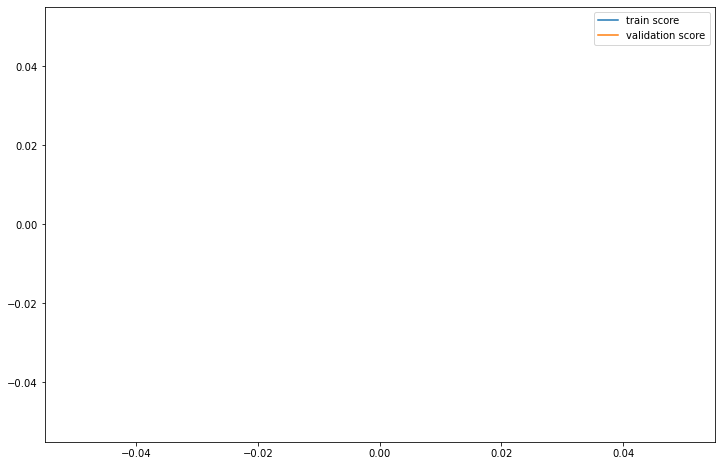

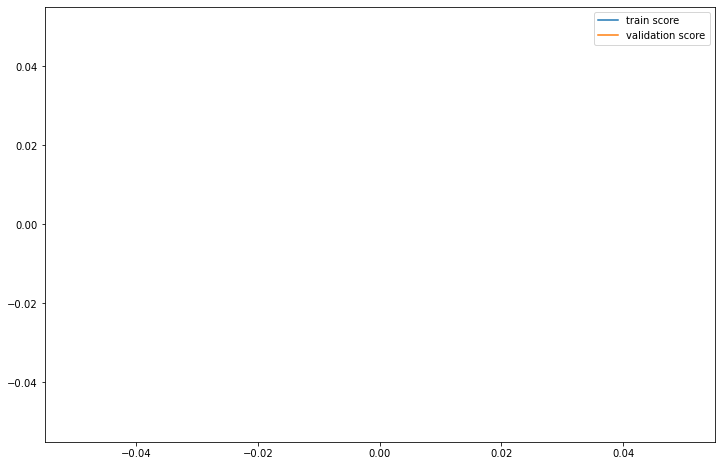

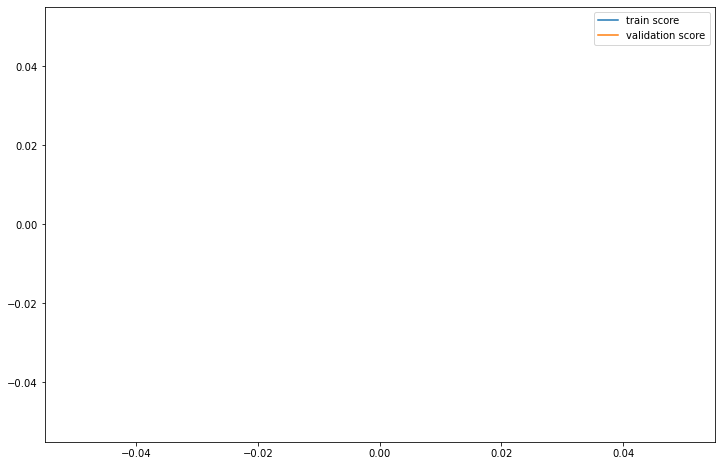

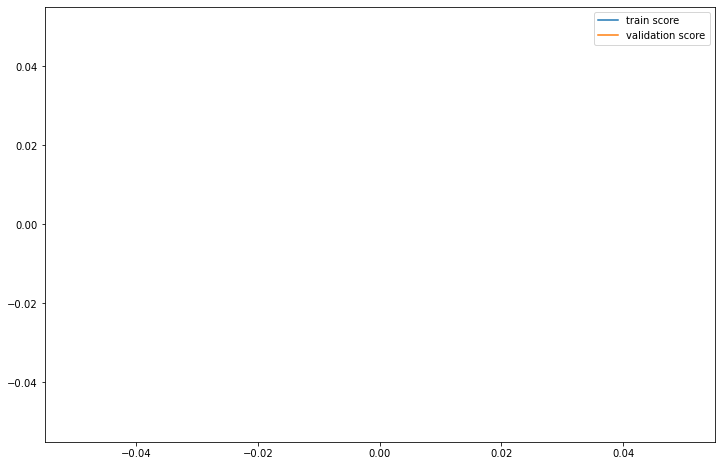

In [95]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

In [101]:
y_scores = cross_val_predict(model_2, X_train, y_train, cv=3, method="predict_proba")

D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   9  50  90 129 167 204 240 275 309 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 553 554 579 628 629 632 651 652 654 673 694
 695 696 697 698 702 714 715 716 717 733 734 735 751 752 768 799 826 827
 828 829 830 831 832 833 838 839 840 841 842 843 844 849 850 851 852 853
 854 859 860 861 862 863 868 869 870 871 876 877 878 883 884 889 898 899
 901] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   9  50  90 129 167 204 240 275 309 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 

In [102]:
y_train_stay = (y_train == 'Yes')
y_test_stay = (y_test == 'Yes')
y_scores

array([[0.97428571, 0.02571429],
       [0.07      , 0.93      ],
       [1.        , 0.        ],
       ...,
       [0.91      , 0.09      ],
       [0.75      , 0.25      ],
       [0.35      , 0.65      ]])

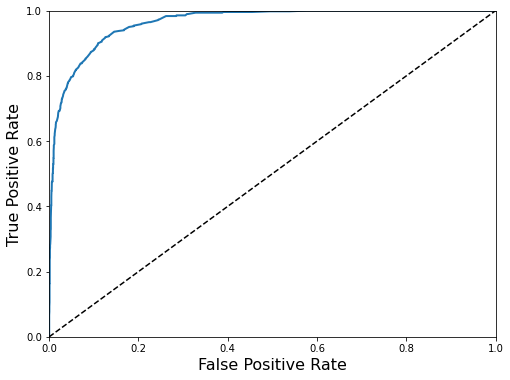

In [103]:
y_scores_forest = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_train_stay, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()